In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import random
import math
from tqdm import tqdm

# Model

In [2]:
def to_np(x):
    return x.detach().cpu().numpy()

In [3]:
def ode_solve(z0, t0, t1, f):
    """
    Simplest Euler ODE initial value solver
    """
    h_max = 0.05
    n_steps = math.ceil((abs(t1 - t0)/h_max).max().item())

    h = (t1 - t0)/n_steps
    t = t0
    z = z0

    for i_step in range(n_steps):
        z = z + h * f(z, t)
        t = t + h
    return z

In [4]:
class VaeODEF(nn.Module):
    def forward_grad(self, z, t, grad_out):
        batch_size = z.shape[0] 
        out = self.forward(z, t)

        a = grad_out
        adfdz, *adfdp = torch.autograd.grad((out,), (z, self.p) , grad_outputs=(a), allow_unused=True, retain_graph=True)
        
        if adfdp is not None:
            adfdp = torch.cat([p_grad.flatten() for p_grad in adfdp]).unsqueeze(0)
            adfdp = adfdp.expand(batch_size, -1) / batch_size

        return adfdz, adfdp

In [5]:
class Dynamical_system_layer(torch.autograd.Function):
    @staticmethod
    def forward(ctx, z0, t, flat_parameters, func):
        assert isinstance(func, VaeODEF)
        batch_size, *z_dim = z0.size()
        time_len = t.size(0)
        
        with torch.no_grad():
            z = torch.zeros(time_len, batch_size, *z_dim).to(z0)
            z[0] = z0
            for it in range(time_len - 1):
                z0 = ode_solve(z0, t[it], t[it+1], func)
                z[it+1] = z0
                
        ctx.func = func
        ctx.save_for_backward(t, z.clone(), flat_parameters)
        return z
    
    @staticmethod
    def backward(ctx, grad_out):
        func = ctx.func
        t, z, flat_parameters = ctx.saved_tensors
        time_len, batch_size, *z_dim = z.size()
        n_param = flat_parameters.size(1)
            
        #grad_out = grad_out.view(time_len, batch_size, z_dim)
            
            
        with torch.no_grad():
    
            adzdp = torch.zeros(time_len, batch_size, *z_dim, n_param).to(grad_out)
            u = adzdp[0]
            for it in range(time_len - 1):
                
                zi = z[it]
                ti = t[it]
                
                ai = grad_out[it]
                
                #zi = zi.view(batch_size, z_dim)
                #ai = ai.view(batch_size, z_dim)
                with torch.set_grad_enabled(True):
                    zi = zi.detach().requires_grad_(True)
                    adfdz, adfdp = func.forward_grad(zi, ti, ai)
                    
                    adfdp = adfdp.to(zi) if adfdp is not None else torch.zeros(batch_size, n_param)
                    
                def dual_dynamic(u, t):
                    return adfdz.matmul(u) + adfdp.unsqueeze(0)
                
                u = ode_solve(u, ti, t[it+1], dual_dynamic)
                
                adzdp[it+1] = u
                
        return adzdp, None, None, None

In [62]:
dzdp = torch.randn(1,2,4)
dzdp.shape

torch.Size([1, 2, 4])

In [63]:
agrad = a.matmul(dzdp)
agrad.shape

torch.Size([1, 1, 4])

In [15]:
u = torch.randn(10, 2, 4)
u = a.matmul(u)
u.shape

torch.Size([10, 10, 4])

In [5]:
gr1 = torch.randn(10, 2, 2)
gr2 = torch.randn(10, 2, 4)
a = torch.randn(20)

In [6]:
a.shape

torch.Size([20])

In [7]:
a=a.view(10, 2)
a.shape

torch.Size([10, 2])

In [16]:
v = torch.Tensor(10, 2, 4)

In [11]:
ag1 = a.matmul(gr1)
ag1.shape

torch.Size([10, 10, 2])

In [18]:
agr1 = ag1.matmul(v)
agr1.shape

torch.Size([10, 10, 4])

In [20]:
ag2 = a.matmul(gr2)
ag2.shape

torch.Size([10, 10, 4])

In [6]:
class VaeNeuralODE(nn.Module):
    def __init__(self, func):
        super(VaeNeuralODE, self).__init__()
        assert isinstance(func, VaeODEF)
        self.func = func
        self.param = self.func.p
        
    def forward(self, z0, t, return_whole_sequence=False):
        t = t.to(z0)
        z = Dynamical_system_layer.apply(z0, t, self.param, self.func)
        if return_whole_sequence:
            return z
        else:
            return z[-1]

In [7]:
class LinearODEF(VaeODEF):
    def __init__(self, p):
        super(LinearODEF, self).__init__()
        self.p = p.detach().requires_grad_(True)
        self.mat_dim = int(self.p.shape[1]**0.5)
        
    def forward(self, x, t):
        A = self.p.reshape(self.mat_dim, self.mat_dim)
        out = x.matmul(A)
        return out

In [25]:
p = torch.Tensor([[0., 1., -1., 0]])
p.reshape(int(p.shape[1]**0.5), int(p.shape[1]**0.5))
A = p.reshape(int(p.shape[1]**0.5), int(p.shape[1]**0.5))

In [56]:
pend = LinearODEF(p)
ode_true = VaeNeuralODE(pend)
ode_true

VaeNeuralODE(
  (func): LinearODEF()
)

In [57]:
pend.p

tensor([[ 0.,  1., -1.,  0.]], requires_grad=True)

In [44]:
tuple(nn.Linear(2,2).parameters())

(Parameter containing:
 tensor([[-0.4621, -0.1349],
         [ 0.6370, -0.5632]], requires_grad=True), Parameter containing:
 tensor([-0.6759,  0.6243], requires_grad=True))

In [43]:
tuple(nn.ReLU().parameters())

()

In [27]:
z0 = torch.Tensor([[0.,1.]])
t_max = 6.29*5
n_points = 100

index_np = np.arange(0, n_points, 1, dtype=np.int)
index_np = np.hstack([index_np[:, None]])
times_np = np.linspace(0, t_max, num=n_points)
times_np = np.hstack([times_np[:, None]])

times = torch.from_numpy(times_np[:, :, None]).to(z0)

z = ode_true(z0, times, return_whole_sequence=True)

In [38]:
a = torch.randn(1,2)
a.shape

torch.Size([1, 2])

In [46]:
pend.p.requires_grad_(True)

tensor([[ 0.,  1., -1.,  0.]], requires_grad=True)

In [47]:
z = z.detach().requires_grad_(True)
grad1, grad2 = pend.forward_grad(z[10], times[10], a)

In [48]:
print('grad 1:', grad1.shape)
print('grad 2:', grad2.shape)

grad 1: torch.Size([1, 2])
grad 2: torch.Size([1, 4])


In [393]:
h = torch.randn(1,2,4)
h.shape

torch.Size([1, 2, 4])

In [50]:
gradtr = grad1.matmul(h)
gradtr.shape

torch.Size([1, 1, 4])

In [51]:
gradtr2 = grad2.unsqueeze(0)
gradtr2.shape

torch.Size([1, 1, 4])

In [59]:
g = gradtr + gradtr2
g.shape

torch.Size([1, 1, 4])

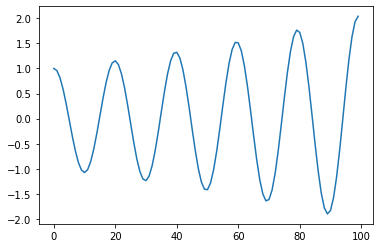

In [28]:
plt.plot(z[:,0,1].numpy())
plt.show()

In [8]:
class EncoderFC(nn.Module):
    def __init__(self, input_dim, hidden_dim, param_dim):
        super(EncoderFC, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.param_dim = param_dim
        
        self.lin1 = nn.Linear(self.input_dim, self.hidden_dim)
        self.selu = nn.SELU()
        self.lin2 = nn.Linear(self.hidden_dim, self.param_dim)
        
    def forward(self, x):
        x = x.view(-1)
        out = self.lin1(x)
        out = self.selu(out)
        out = self.lin2(out)
        out = self.selu(out)
        out = out.view(1,len(out))
        return out
        

In [9]:
class DecoderVaeODE(nn.Module):
    def __init__(self, hidden_dim, input_dim):
        super(DecoderVaeODE, self).__init__()
        self.hidden_dim = hidden_dim
        self.input_dim = input_dim
        
        self.lin1 = nn.Linear(self.input_dim, self.hidden_dim)
        self.selu = nn.SELU()
        self.lin2 = nn.Linear(self.hidden_dim, self.input_dim)
        
    def forward(self, z0, t, p):
        func = LinearODEF(p)
        self.ode = VaeNeuralODE(func)
        z = self.ode(z0, t, return_whole_sequence=True)
        y = z.squeeze(1)
        y = y[:,0]
        out = self.lin1(y)
        out = self.selu(out)
        out = self.lin2(out)
        out = self.selu(out)
        out = out.view(len(out), 1)
        return out

In [10]:
class VaeODENeuralNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, param_dim):
        super(VaeODENeuralNet, self).__init__()
        self.input_dim = input_dim
        self.param_dim = param_dim
        self.hidden_dim = hidden_dim
        
        self.param_encoder = EncoderFC(self.input_dim, self.hidden_dim, self.param_dim)
        self.ode_decoder = DecoderVaeODE(self.hidden_dim, self.input_dim)
        
    def forward(self, x, t):
        x = x.view(1,len(x))
        p = self.param_encoder(x)
        z0 = torch.Tensor([[x[:,0], x[:,1]]])
        z = self.ode_decoder(z0, t, p)
        return z, p

In [13]:
class SimpleVaeODENeuralNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, param_dim):
        super(SimpleVaeODENeuralNet, self).__init__()
        self.input_dim = input_dim
        self.param_dim = param_dim
        self.hidden_dim = hidden_dim
        
        self.param_encoder = EncoderFC(self.input_dim, self.hidden_dim, self.param_dim)
        
    def forward(self, x, t):
        x = x.view(1,len(x))
        p = self.param_encoder(x)
        z0 = torch.Tensor([[x[:,0], x[:,1]]])
        func = LinearODEF(p)
        self.ode = VaeNeuralODE(func)
        z = self.ode(z0, t, return_whole_sequence=True)
        y = z.squeeze(1)
        out = y[:,0]
        out = out.view(len(out), 1)
        return out, p

In [38]:
obs.shape

torch.Size([200, 1, 2])

In [175]:
ode_train = VaeODENeuralNet(200, 10, 4)

In [139]:
ode_train

VaeODENeuralNet(
  (param_encoder): EncoderFC(
    (lin1): Linear(in_features=200, out_features=10, bias=True)
    (relu): ReLU()
    (lin2): Linear(in_features=10, out_features=4, bias=True)
  )
  (ode_decoder): DecoderVaeODE(
    (lin1): Linear(in_features=200, out_features=10, bias=True)
    (relu): ReLU()
    (lin2): Linear(in_features=10, out_features=200, bias=True)
  )
)

In [43]:
obs.shape

torch.Size([200, 1, 2])

In [180]:
x = obs.squeeze(1)
x.shape

torch.Size([200, 2])

In [181]:
x = x[:,0]
x.shape

torch.Size([200])

In [173]:
torch.Tensor([[x[:,0],x[:,1]]]).shape

torch.Size([1, 2])

In [162]:
z0.shape

torch.Size([1, 2])

In [118]:
y = x.view(-1)
y.view(1,200).shape

torch.Size([1, 200])

In [125]:
encoder_param = EncoderFC(200, 10, 4)
param = encoder_param(x)
param = param.view(1,4)
param.shape

torch.Size([1, 4])

In [127]:
int(param.shape[1]**0.5)

2

In [133]:
int(param.detach().requires_grad_(True).shape[1]**0.5)

2

In [120]:
decoder_ode = DecoderVaeODE(10, 200)
out = decoder_ode(z0, times, param)
out = out.view(1,len(out))
out.shape

torch.Size([1, 200])

In [145]:
z0.size()

torch.Size([1, 2])

In [183]:
out = ode_train(x, times)
out.shape

torch.Size([1, 200])

In [200]:
obs = obs.squeeze(1)
obs.shape

torch.Size([200, 2])

In [201]:
time_len = 200
input_dim = obs.shape[1]
ode_train = NeuralLinearODE(time_len, input_dim)

In [202]:
ode_train

NeuralLinearODE(
  (encoder): Param_FC_layer(
    (lin): Linear(in_features=200, out_features=4, bias=True)
  )
)

In [203]:
ode_train.A

tensor([[ 0.8915,  0.1539],
        [-0.3961, -0.6322]])

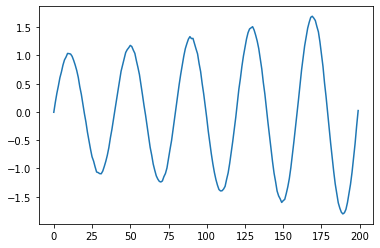

In [168]:
obs = obs.squeeze(1)
plt.plot(obs[:,0].detach().numpy())
plt.show()

In [186]:
out = ode_train(obs, times)

tensor([[-0.9399,  0.2392],
        [ 0.6336, -0.6704]], requires_grad=True)


In [148]:
out = out.squeeze(1)

In [149]:
out.shape

torch.Size([200, 2])

In [15]:
def batch_sampling(obs, times, t_max, batch_size = 100, delta=50):
    obs_ = torch.zeros((batch_size, delta, obs.shape[1], obs.shape[2]))
    ts_ = torch.zeros((batch_size, delta, times.shape[1], times.shape[2]))
    
    for b in range(batch_size):
        t0 = np.random.uniform(0, float(t_max))
        t1 = float(t0) + delta
        idx = np.arange(t0,t1)
        if len(idx) == delta:
            obs_[b,:,:] = obs[idx]
            ts_[b,:,:] = times[idx]
    
    return obs_, ts_

In [321]:
z0 = Variable(torch.Tensor([[0.,1.]]))
p = torch.Tensor([[0., 1., -1., 0]])
save_result = True

t_max = 6.29*5
n_points = 200

index_np = np.arange(0, n_points, 1, dtype=np.int)
index_np = np.hstack([index_np[:, None]])
times_np = np.linspace(0, t_max, num=n_points)
times_np = np.hstack([times_np[:, None]])

times = torch.from_numpy(times_np[:, :, None]).to(z0)
ode_true = VaeNeuralODE(LinearODEF(p))
print('Real matrix:')
print(ode_true.param.view(2,2))
obs = ode_true(z0, times, return_whole_sequence=True).detach()
obs = obs + torch.randn_like(obs) * 0.01

Real matrix:
tensor([[ 0.,  1.],
        [-1.,  0.]], grad_fn=<ViewBackward>)


In [361]:
times.shape

torch.Size([200, 1, 1])

In [363]:
times[1+1]

tensor([[0.3161]])

In [324]:
obs.shape

torch.Size([200, 1, 2])

In [233]:
x = obs.squeeze(1)
x.shape

torch.Size([200, 2])

In [14]:
obs.shape

torch.Size([200, 1, 2])

In [17]:
z0.shape

torch.Size([1, 2])

In [18]:
A.shape

torch.Size([2, 2])

In [19]:
obs_, ts_ = batch_sampling(obs, times, t_max)

In [80]:
obs = obs.detach().requires_grad_(True)

# Testing some line

In [184]:
p = torch.Tensor([[0., 1., -1., 0]])
p.shape

torch.Size([1, 4])

In [223]:
w = nn.Linear(2,2).weight
z0.matmul(w)

tensor([[ 0.5872, -0.0268]], grad_fn=<MmBackward>)

In [257]:
obs.shape

torch.Size([200, 1, 2])

In [256]:
x = obs[0:50,:,0]
x.shape

torch.Size([50, 1])

In [263]:
x = x.squeeze(1)
x.shape

torch.Size([50])

In [277]:
ode_train = VaeODENeuralNet(50, 10, 4)
z_, p = ode_train(x, t)
z_ = z_.squeeze(1)
loss = loss_fn(z_, x.detach())

In [278]:
loss

tensor(0.6638, grad_fn=<MseLossBackward>)

In [255]:
ode_train

VaeODENeuralNet(
  (param_encoder): EncoderFC(
    (lin1): Linear(in_features=50, out_features=10, bias=True)
    (relu): ReLU()
    (lin2): Linear(in_features=10, out_features=4, bias=True)
  )
  (ode_decoder): DecoderVaeODE(
    (lin1): Linear(in_features=50, out_features=10, bias=True)
    (relu): ReLU()
    (lin2): Linear(in_features=10, out_features=50, bias=True)
    (ode): VaeNeuralODE(
      (func): LinearODEF()
    )
  )
)

In [325]:
x = obs[:,:,0]
x.shape

torch.Size([200, 1])

In [328]:
y = x.view(x.shape, 1)
y.shape

torch.Size([200, 1])

# Training the model

  0%|          | 0/100 [00:00<?, ?it/s]

Real A:
tensor([[ 0.,  1.],
        [-1.,  0.]], grad_fn=<ViewBackward>)
Beginning training...
predicted A:
tensor([[ 0.3376,  0.6633],
        [-0.1252,  0.3294]], grad_fn=<AsStridedBackward>)
epoch: 1
step: 100
train loss: 12.461271421313286


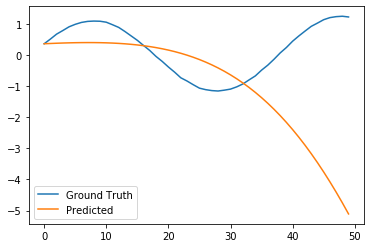

  2%|▏         | 2/100 [00:06<05:25,  3.32s/it]

predicted A:
tensor([[ 0.1645, -0.5962],
        [ 0.1045, -0.3284]], grad_fn=<AsStridedBackward>)
epoch: 2
step: 200
train loss: 7.188488038343191


  3%|▎         | 3/100 [00:09<05:19,  3.30s/it]

predicted A:
tensor([[ 0.1062, -0.6419],
        [ 0.0999, -0.2908]], grad_fn=<AsStridedBackward>)
epoch: 3
step: 300
train loss: 8.929486429412782


  4%|▍         | 4/100 [00:13<05:17,  3.31s/it]

predicted A:
tensor([[0.0742, 0.2598],
        [0.0222, 0.4220]], grad_fn=<AsStridedBackward>)
epoch: 4
step: 400
train loss: 8.78048455035408


  5%|▌         | 5/100 [00:16<05:06,  3.22s/it]

predicted A:
tensor([[-0.0623,  0.0319],
        [ 0.0726,  0.3843]], grad_fn=<AsStridedBackward>)
epoch: 5
step: 500
train loss: 7.307932365468713


  6%|▌         | 6/100 [00:19<04:56,  3.16s/it]

predicted A:
tensor([[ 0.0617, -0.6671],
        [ 0.1072, -0.2403]], grad_fn=<AsStridedBackward>)
epoch: 6
step: 600
train loss: 4.113493997340715


  7%|▋         | 7/100 [00:22<04:48,  3.10s/it]

predicted A:
tensor([[ 0.4129,  0.6864],
        [-0.1437,  0.2592]], grad_fn=<AsStridedBackward>)
epoch: 7
step: 700
train loss: 10.978431725089603


  8%|▊         | 8/100 [00:24<04:39,  3.04s/it]

predicted A:
tensor([[-0.1974, -0.3875],
        [ 0.0897,  0.2459]], grad_fn=<AsStridedBackward>)
epoch: 8
step: 800
train loss: 12.938361424441982


  9%|▉         | 9/100 [00:28<04:39,  3.08s/it]

predicted A:
tensor([[ 0.4850,  0.5424],
        [-0.0954,  0.0154]], grad_fn=<AsStridedBackward>)
epoch: 9
step: 900
train loss: 14.645612869443854


 10%|█         | 10/100 [00:31<04:46,  3.18s/it]

predicted A:
tensor([[-0.1978, -0.6088],
        [ 0.1160,  0.0965]], grad_fn=<AsStridedBackward>)
epoch: 10
step: 1000
train loss: 9.310584405996227
predicted A:
tensor([[-0.2037, -0.5615],
        [ 0.1057,  0.1434]], grad_fn=<AsStridedBackward>)
epoch: 11
step: 1100
train loss: 13.847800586620348


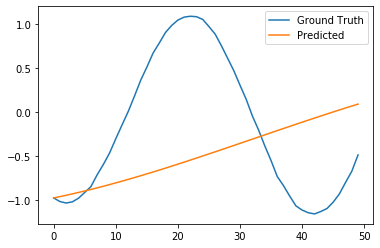

 12%|█▏        | 12/100 [00:38<04:46,  3.26s/it]

predicted A:
tensor([[-0.2037, -0.5615],
        [ 0.1057,  0.1434]], grad_fn=<AsStridedBackward>)
epoch: 12
step: 1200
train loss: 6.9427072123090365


 13%|█▎        | 13/100 [00:41<04:34,  3.16s/it]

predicted A:
tensor([[0.1667, 0.0456],
        [0.0354, 0.0690]], grad_fn=<AsStridedBackward>)
epoch: 13
step: 1300
train loss: 6.770920089200537


 14%|█▍        | 14/100 [00:44<04:26,  3.09s/it]

predicted A:
tensor([[ 0.4841,  0.6566],
        [-0.1078,  0.1536]], grad_fn=<AsStridedBackward>)
epoch: 14
step: 1400
train loss: 10.146751214775596


 15%|█▌        | 15/100 [00:47<04:28,  3.16s/it]

predicted A:
tensor([[0.0340, 0.1898],
        [0.0443, 0.4235]], grad_fn=<AsStridedBackward>)
epoch: 15
step: 1500
train loss: 11.351566164987416


 16%|█▌        | 16/100 [00:50<04:24,  3.15s/it]

predicted A:
tensor([[ 0.0214, -0.6764],
        [ 0.1104, -0.1758]], grad_fn=<AsStridedBackward>)
epoch: 16
step: 1600
train loss: 12.88461711078184


 17%|█▋        | 17/100 [00:53<04:14,  3.07s/it]

predicted A:
tensor([[0.1667, 0.0456],
        [0.0354, 0.0690]], grad_fn=<AsStridedBackward>)
epoch: 17
step: 1700
train loss: 7.55742139300399


 18%|█▊        | 18/100 [00:56<04:05,  3.00s/it]

predicted A:
tensor([[ 0.4631,  0.2928],
        [-0.0549, -0.2309]], grad_fn=<AsStridedBackward>)
epoch: 18
step: 1800
train loss: 13.274829880662828


 19%|█▉        | 19/100 [00:59<04:04,  3.02s/it]

predicted A:
tensor([[-0.1440, -0.6492],
        [ 0.1045,  0.0447]], grad_fn=<AsStridedBackward>)
epoch: 19
step: 1900
train loss: 12.057665552658518


 20%|██        | 20/100 [01:02<04:05,  3.07s/it]

predicted A:
tensor([[ 0.4841,  0.6566],
        [-0.1078,  0.1536]], grad_fn=<AsStridedBackward>)
epoch: 20
step: 2000
train loss: 10.761941661496587
predicted A:
tensor([[-0.2037, -0.5615],
        [ 0.1057,  0.1434]], grad_fn=<AsStridedBackward>)
epoch: 21
step: 2100
train loss: 9.149644227525192


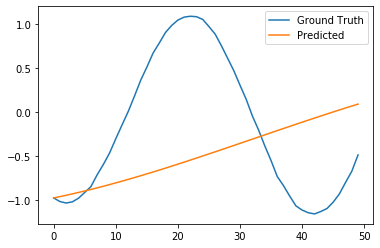

 22%|██▏       | 22/100 [01:09<04:04,  3.14s/it]

predicted A:
tensor([[0.0742, 0.2598],
        [0.0222, 0.4220]], grad_fn=<AsStridedBackward>)
epoch: 22
step: 2200
train loss: 7.156098853068556


 23%|██▎       | 23/100 [01:12<03:58,  3.10s/it]

predicted A:
tensor([[ 0.1645, -0.5962],
        [ 0.1045, -0.3284]], grad_fn=<AsStridedBackward>)
epoch: 23
step: 2300
train loss: 11.334189128384164


 24%|██▍       | 24/100 [01:14<03:51,  3.05s/it]

predicted A:
tensor([[ 0.4900,  0.6031],
        [-0.1022,  0.0864]], grad_fn=<AsStridedBackward>)
epoch: 24
step: 2400
train loss: 7.463827182168814


 25%|██▌       | 25/100 [01:17<03:43,  2.98s/it]

predicted A:
tensor([[ 0.2923,  0.6289],
        [-0.1154,  0.3569]], grad_fn=<AsStridedBackward>)
epoch: 25
step: 2500
train loss: 12.815827698601435


 26%|██▌       | 26/100 [01:20<03:36,  2.92s/it]

predicted A:
tensor([[-0.1577, -0.2528],
        [ 0.0928,  0.2980]], grad_fn=<AsStridedBackward>)
epoch: 26
step: 2600
train loss: 9.19026425988568


 27%|██▋       | 27/100 [01:23<03:32,  2.91s/it]

predicted A:
tensor([[ 0.3804,  0.6830],
        [-0.1366,  0.2952]], grad_fn=<AsStridedBackward>)
epoch: 27
step: 2700
train loss: 8.840801840773333


 28%|██▊       | 28/100 [01:26<03:28,  2.90s/it]

predicted A:
tensor([[ 0.4572,  0.6740],
        [-0.1215,  0.2106]], grad_fn=<AsStridedBackward>)
epoch: 28
step: 2800
train loss: 5.9962853277300905


 29%|██▉       | 29/100 [01:29<03:33,  3.01s/it]

predicted A:
tensor([[-0.2070, -0.4872],
        [ 0.0950,  0.1888]], grad_fn=<AsStridedBackward>)
epoch: 29
step: 2900
train loss: 10.790977912033178


 30%|███       | 30/100 [01:33<03:42,  3.17s/it]

predicted A:
tensor([[ 0.4662,  0.4626],
        [-0.0884, -0.0877]], grad_fn=<AsStridedBackward>)
epoch: 30
step: 3000
train loss: 14.75228160815323
predicted A:
tensor([[ 0.4129,  0.6864],
        [-0.1437,  0.2592]], grad_fn=<AsStridedBackward>)
epoch: 31
step: 3100
train loss: 11.65405299605895


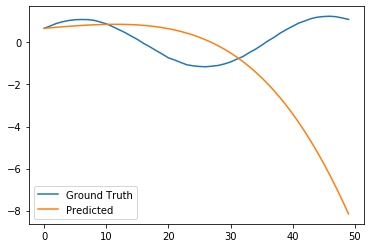

 32%|███▏      | 32/100 [01:41<03:59,  3.52s/it]

predicted A:
tensor([[ 0.1062, -0.6419],
        [ 0.0999, -0.2908]], grad_fn=<AsStridedBackward>)
epoch: 32
step: 3200
train loss: 10.880234908098178


 33%|███▎      | 33/100 [01:44<04:00,  3.58s/it]

predicted A:
tensor([[ 0.0617, -0.6671],
        [ 0.1072, -0.2403]], grad_fn=<AsStridedBackward>)
epoch: 33
step: 3300
train loss: 11.953168732633532


 34%|███▍      | 34/100 [01:48<04:01,  3.66s/it]

predicted A:
tensor([[-0.1974, -0.3875],
        [ 0.0897,  0.2459]], grad_fn=<AsStridedBackward>)
epoch: 34
step: 3400
train loss: 14.693486182517908


 35%|███▌      | 35/100 [01:52<03:57,  3.66s/it]

predicted A:
tensor([[ 0.0617, -0.6671],
        [ 0.1072, -0.2403]], grad_fn=<AsStridedBackward>)
epoch: 35
step: 3500
train loss: 7.7168657651407235


 36%|███▌      | 36/100 [01:55<03:50,  3.60s/it]

predicted A:
tensor([[ 0.4572,  0.6740],
        [-0.1215,  0.2106]], grad_fn=<AsStridedBackward>)
epoch: 36
step: 3600
train loss: 11.77685281621502


 37%|███▋      | 37/100 [01:59<03:41,  3.52s/it]

predicted A:
tensor([[ 0.3376,  0.6633],
        [-0.1252,  0.3294]], grad_fn=<AsStridedBackward>)
epoch: 37
step: 3700
train loss: 13.411175310908465


 38%|███▊      | 38/100 [02:02<03:36,  3.49s/it]

predicted A:
tensor([[0.0068, 0.1078],
        [0.0652, 0.4121]], grad_fn=<AsStridedBackward>)
epoch: 38
step: 3800
train loss: 10.635894905927763


 39%|███▉      | 39/100 [02:06<03:41,  3.64s/it]

predicted A:
tensor([[ 0.4639,  0.3816],
        [-0.0649, -0.1764]], grad_fn=<AsStridedBackward>)
epoch: 39
step: 3900
train loss: 14.049409387820988


 40%|████      | 40/100 [02:09<03:29,  3.49s/it]

predicted A:
tensor([[ 0.0617, -0.6671],
        [ 0.1072, -0.2403]], grad_fn=<AsStridedBackward>)
epoch: 40
step: 4000
train loss: 8.044388713819922
predicted A:
tensor([[ 0.3376,  0.6633],
        [-0.1252,  0.3294]], grad_fn=<AsStridedBackward>)
epoch: 41
step: 4100
train loss: 12.520225087427924


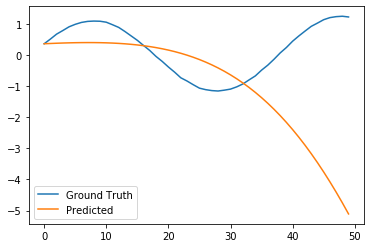

 42%|████▏     | 42/100 [02:15<03:06,  3.21s/it]

predicted A:
tensor([[ 0.4900,  0.6031],
        [-0.1022,  0.0864]], grad_fn=<AsStridedBackward>)
epoch: 42
step: 4200
train loss: 10.54912712076926


 43%|████▎     | 43/100 [02:18<02:58,  3.12s/it]

predicted A:
tensor([[-0.0295, -0.6853],
        [ 0.1119, -0.1070]], grad_fn=<AsStridedBackward>)
epoch: 43
step: 4300
train loss: 10.355853815863492


 44%|████▍     | 44/100 [02:21<02:52,  3.07s/it]

predicted A:
tensor([[-0.0623,  0.0319],
        [ 0.0726,  0.3843]], grad_fn=<AsStridedBackward>)
epoch: 44
step: 4400
train loss: 9.317532077630261


 45%|████▌     | 45/100 [02:24<02:51,  3.12s/it]

predicted A:
tensor([[ 0.1645, -0.5962],
        [ 0.1045, -0.3284]], grad_fn=<AsStridedBackward>)
epoch: 45
step: 4500
train loss: 7.069996595533688


 46%|████▌     | 46/100 [02:27<02:44,  3.04s/it]

predicted A:
tensor([[ 0.3376,  0.6633],
        [-0.1252,  0.3294]], grad_fn=<AsStridedBackward>)
epoch: 46
step: 4600
train loss: 9.16609147489222


 47%|████▋     | 47/100 [02:30<02:39,  3.00s/it]

predicted A:
tensor([[0.1667, 0.0456],
        [0.0354, 0.0690]], grad_fn=<AsStridedBackward>)
epoch: 47
step: 4700
train loss: 12.966738206475988


 48%|████▊     | 48/100 [02:33<02:35,  3.00s/it]

predicted A:
tensor([[0.0068, 0.1078],
        [0.0652, 0.4121]], grad_fn=<AsStridedBackward>)
epoch: 48
step: 4800
train loss: 10.988600176397263


 49%|████▉     | 49/100 [02:36<02:40,  3.15s/it]

predicted A:
tensor([[0.1667, 0.0456],
        [0.0354, 0.0690]], grad_fn=<AsStridedBackward>)
epoch: 49
step: 4900
train loss: 13.538587513385448


 50%|█████     | 50/100 [02:40<02:47,  3.36s/it]

predicted A:
tensor([[ 0.3376,  0.6633],
        [-0.1252,  0.3294]], grad_fn=<AsStridedBackward>)
epoch: 50
step: 5000
train loss: 12.347674398450238
predicted A:
tensor([[-0.0913, -0.6753],
        [ 0.1103, -0.0254]], grad_fn=<AsStridedBackward>)
epoch: 51
step: 5100
train loss: 8.185465762305538


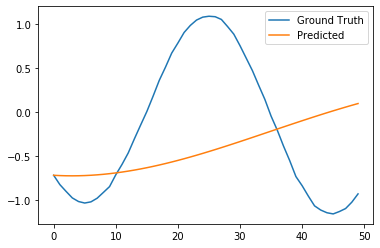

 52%|█████▏    | 52/100 [02:47<02:45,  3.45s/it]

predicted A:
tensor([[0.0068, 0.1078],
        [0.0652, 0.4121]], grad_fn=<AsStridedBackward>)
epoch: 52
step: 5200
train loss: 9.203937696310762


 53%|█████▎    | 53/100 [02:51<02:51,  3.64s/it]

predicted A:
tensor([[-0.0913, -0.6753],
        [ 0.1103, -0.0254]], grad_fn=<AsStridedBackward>)
epoch: 53
step: 5300
train loss: 17.14167258488032


 54%|█████▍    | 54/100 [02:55<02:45,  3.59s/it]

predicted A:
tensor([[0.0742, 0.2598],
        [0.0222, 0.4220]], grad_fn=<AsStridedBackward>)
epoch: 54
step: 5400
train loss: 11.245191172693858


 55%|█████▌    | 55/100 [02:58<02:37,  3.49s/it]

predicted A:
tensor([[ 0.0214, -0.6764],
        [ 0.1104, -0.1758]], grad_fn=<AsStridedBackward>)
epoch: 55
step: 5500
train loss: 7.532715609827983


 56%|█████▌    | 56/100 [03:01<02:28,  3.38s/it]

predicted A:
tensor([[ 0.4572,  0.6740],
        [-0.1215,  0.2106]], grad_fn=<AsStridedBackward>)
epoch: 56
step: 5600
train loss: 9.408029628904256


 57%|█████▋    | 57/100 [03:04<02:20,  3.26s/it]

predicted A:
tensor([[-0.1440, -0.6492],
        [ 0.1045,  0.0447]], grad_fn=<AsStridedBackward>)
epoch: 57
step: 5700
train loss: 11.347809813748913


 58%|█████▊    | 58/100 [03:07<02:12,  3.16s/it]

predicted A:
tensor([[-0.0623,  0.0319],
        [ 0.0726,  0.3843]], grad_fn=<AsStridedBackward>)
epoch: 58
step: 5800
train loss: 15.44332636318933


 59%|█████▉    | 59/100 [03:10<02:06,  3.08s/it]

predicted A:
tensor([[ 0.4841,  0.6566],
        [-0.1078,  0.1536]], grad_fn=<AsStridedBackward>)
epoch: 59
step: 5900
train loss: 8.277886217328144


 60%|██████    | 60/100 [03:13<02:01,  3.04s/it]

predicted A:
tensor([[0.1667, 0.0456],
        [0.0354, 0.0690]], grad_fn=<AsStridedBackward>)
epoch: 60
step: 6000
train loss: 10.596627557928286
predicted A:
tensor([[-0.0913, -0.6753],
        [ 0.1103, -0.0254]], grad_fn=<AsStridedBackward>)
epoch: 61
step: 6100
train loss: 13.8396444066828


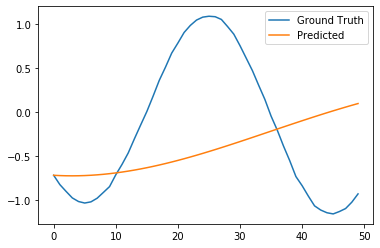

 62%|██████▏   | 62/100 [03:19<01:53,  2.99s/it]

predicted A:
tensor([[-0.0913, -0.6753],
        [ 0.1103, -0.0254]], grad_fn=<AsStridedBackward>)
epoch: 62
step: 6200
train loss: 7.489473848089045


 63%|██████▎   | 63/100 [03:22<01:50,  2.98s/it]

predicted A:
tensor([[-0.1978, -0.6088],
        [ 0.1160,  0.0965]], grad_fn=<AsStridedBackward>)
epoch: 63
step: 6300
train loss: 12.686624160096493


 64%|██████▍   | 64/100 [03:26<01:54,  3.19s/it]

predicted A:
tensor([[ 0.4900,  0.6031],
        [-0.1022,  0.0864]], grad_fn=<AsStridedBackward>)
epoch: 64
step: 6400
train loss: 12.367738736775372


 65%|██████▌   | 65/100 [03:29<01:49,  3.14s/it]

predicted A:
tensor([[ 0.4900,  0.6031],
        [-0.1022,  0.0864]], grad_fn=<AsStridedBackward>)
epoch: 65
step: 6500
train loss: 10.12104359401372


 66%|██████▌   | 66/100 [03:32<01:46,  3.14s/it]

predicted A:
tensor([[ 0.4572,  0.6740],
        [-0.1215,  0.2106]], grad_fn=<AsStridedBackward>)
epoch: 66
step: 6600
train loss: 12.227738775922171


 67%|██████▋   | 67/100 [03:35<01:42,  3.12s/it]

predicted A:
tensor([[-0.1021, -0.0924],
        [ 0.0963,  0.3552]], grad_fn=<AsStridedBackward>)
epoch: 67
step: 6700
train loss: 13.208469459793104


 68%|██████▊   | 68/100 [03:38<01:37,  3.06s/it]

predicted A:
tensor([[ 0.4639,  0.3816],
        [-0.0649, -0.1764]], grad_fn=<AsStridedBackward>)
epoch: 68
step: 6800
train loss: 12.375954147670479


 69%|██████▉   | 69/100 [03:41<01:35,  3.09s/it]

predicted A:
tensor([[-0.1978, -0.6088],
        [ 0.1160,  0.0965]], grad_fn=<AsStridedBackward>)
epoch: 69
step: 6900
train loss: 11.507977426613309


 70%|███████   | 70/100 [03:44<01:31,  3.06s/it]

predicted A:
tensor([[ 0.1973,  0.5181],
        [-0.0802,  0.3887]], grad_fn=<AsStridedBackward>)
epoch: 70
step: 7000
train loss: 6.505582435732731
predicted A:
tensor([[ 0.4129,  0.6864],
        [-0.1437,  0.2592]], grad_fn=<AsStridedBackward>)
epoch: 71
step: 7100
train loss: 17.649462772446928


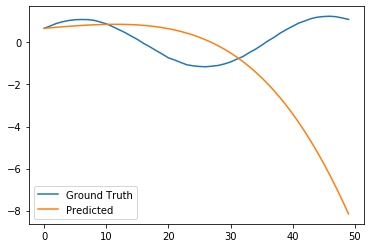

 72%|███████▏  | 72/100 [03:51<01:31,  3.28s/it]

predicted A:
tensor([[ 0.3376,  0.6633],
        [-0.1252,  0.3294]], grad_fn=<AsStridedBackward>)
epoch: 72
step: 7200
train loss: 9.700778247247518


 73%|███████▎  | 73/100 [03:54<01:28,  3.30s/it]

predicted A:
tensor([[ 0.2923,  0.6289],
        [-0.1154,  0.3569]], grad_fn=<AsStridedBackward>)
epoch: 73
step: 7300
train loss: 6.690326217426165


 74%|███████▍  | 74/100 [03:57<01:21,  3.14s/it]

predicted A:
tensor([[ 0.4900,  0.6031],
        [-0.1022,  0.0864]], grad_fn=<AsStridedBackward>)
epoch: 74
step: 7400
train loss: 7.952200629151


 75%|███████▌  | 75/100 [04:00<01:16,  3.08s/it]

predicted A:
tensor([[ 0.4639,  0.3816],
        [-0.0649, -0.1764]], grad_fn=<AsStridedBackward>)
epoch: 75
step: 7500
train loss: 11.489064822572827


 76%|███████▌  | 76/100 [04:03<01:12,  3.03s/it]

predicted A:
tensor([[ 0.1062, -0.6419],
        [ 0.0999, -0.2908]], grad_fn=<AsStridedBackward>)
epoch: 76
step: 7600
train loss: 11.769823401669447


 77%|███████▋  | 77/100 [04:06<01:11,  3.11s/it]

predicted A:
tensor([[-0.0913, -0.6753],
        [ 0.1103, -0.0254]], grad_fn=<AsStridedBackward>)
epoch: 77
step: 7700
train loss: 10.686753664309776


 78%|███████▊  | 78/100 [04:09<01:08,  3.12s/it]

predicted A:
tensor([[ 0.1645, -0.5962],
        [ 0.1045, -0.3284]], grad_fn=<AsStridedBackward>)
epoch: 78
step: 7800
train loss: 18.70071377311046


 79%|███████▉  | 79/100 [04:12<01:05,  3.11s/it]

predicted A:
tensor([[ 0.1973,  0.5181],
        [-0.0802,  0.3887]], grad_fn=<AsStridedBackward>)
epoch: 79
step: 7900
train loss: 6.972447512343913


 80%|████████  | 80/100 [04:16<01:06,  3.33s/it]

predicted A:
tensor([[-0.0295, -0.6853],
        [ 0.1119, -0.1070]], grad_fn=<AsStridedBackward>)
epoch: 80
step: 8000
train loss: 7.737155235387836
predicted A:
tensor([[0.1667, 0.0456],
        [0.0354, 0.0690]], grad_fn=<AsStridedBackward>)
epoch: 81
step: 8100
train loss: 14.272647290593168


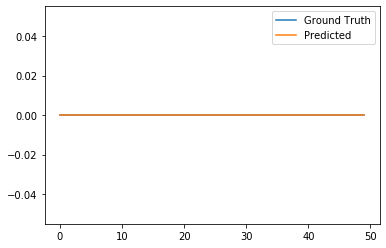

 82%|████████▏ | 82/100 [04:24<01:04,  3.60s/it]

predicted A:
tensor([[-0.1978, -0.6088],
        [ 0.1160,  0.0965]], grad_fn=<AsStridedBackward>)
epoch: 82
step: 8200
train loss: 10.006002508691607


 83%|████████▎ | 83/100 [04:27<01:00,  3.54s/it]

predicted A:
tensor([[-0.0295, -0.6853],
        [ 0.1119, -0.1070]], grad_fn=<AsStridedBackward>)
epoch: 83
step: 8300
train loss: 11.44795750700525


 84%|████████▍ | 84/100 [04:31<00:57,  3.59s/it]

predicted A:
tensor([[ 0.4841,  0.6566],
        [-0.1078,  0.1536]], grad_fn=<AsStridedBackward>)
epoch: 84
step: 8400
train loss: 10.481370120557456


 85%|████████▌ | 85/100 [04:35<00:53,  3.57s/it]

predicted A:
tensor([[ 0.4129,  0.6864],
        [-0.1437,  0.2592]], grad_fn=<AsStridedBackward>)
epoch: 85
step: 8500
train loss: 8.880562817149483


 86%|████████▌ | 86/100 [04:38<00:49,  3.57s/it]

predicted A:
tensor([[ 0.4639,  0.3816],
        [-0.0649, -0.1764]], grad_fn=<AsStridedBackward>)
epoch: 86
step: 8600
train loss: 9.168468473306229


 87%|████████▋ | 87/100 [04:41<00:44,  3.42s/it]

predicted A:
tensor([[0.1667, 0.0456],
        [0.0354, 0.0690]], grad_fn=<AsStridedBackward>)
epoch: 87
step: 8700
train loss: 12.530740107277543


 88%|████████▊ | 88/100 [04:44<00:40,  3.40s/it]

predicted A:
tensor([[-0.1021, -0.0924],
        [ 0.0963,  0.3552]], grad_fn=<AsStridedBackward>)
epoch: 88
step: 8800
train loss: 12.827374842417036


 89%|████████▉ | 89/100 [04:48<00:36,  3.32s/it]

predicted A:
tensor([[-0.1577, -0.2528],
        [ 0.0928,  0.2980]], grad_fn=<AsStridedBackward>)
epoch: 89
step: 8900
train loss: 10.236286307242034


 90%|█████████ | 90/100 [04:51<00:33,  3.33s/it]

predicted A:
tensor([[ 0.4129,  0.6864],
        [-0.1437,  0.2592]], grad_fn=<AsStridedBackward>)
epoch: 90
step: 9000
train loss: 10.369364151605632
predicted A:
tensor([[ 0.1973,  0.5181],
        [-0.0802,  0.3887]], grad_fn=<AsStridedBackward>)
epoch: 91
step: 9100
train loss: 8.56593891927847


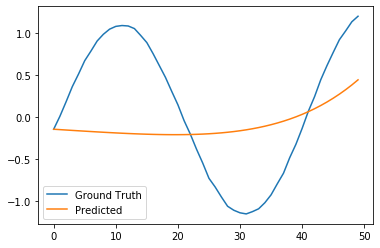

 92%|█████████▏| 92/100 [04:57<00:26,  3.26s/it]

predicted A:
tensor([[-0.0623,  0.0319],
        [ 0.0726,  0.3843]], grad_fn=<AsStridedBackward>)
epoch: 92
step: 9200
train loss: 6.124302423293317


 93%|█████████▎| 93/100 [05:01<00:22,  3.24s/it]

predicted A:
tensor([[ 0.2923,  0.6289],
        [-0.1154,  0.3569]], grad_fn=<AsStridedBackward>)
epoch: 93
step: 9300
train loss: 8.37516374028022


 94%|█████████▍| 94/100 [05:04<00:19,  3.18s/it]

predicted A:
tensor([[ 0.4129,  0.6864],
        [-0.1437,  0.2592]], grad_fn=<AsStridedBackward>)
epoch: 94
step: 9400
train loss: 10.666058804456025


 95%|█████████▌| 95/100 [05:07<00:16,  3.23s/it]

predicted A:
tensor([[-0.0913, -0.6753],
        [ 0.1103, -0.0254]], grad_fn=<AsStridedBackward>)
epoch: 95
step: 9500
train loss: 11.169046185273565


 96%|█████████▌| 96/100 [05:10<00:12,  3.19s/it]

predicted A:
tensor([[ 0.4639,  0.3816],
        [-0.0649, -0.1764]], grad_fn=<AsStridedBackward>)
epoch: 96
step: 9600
train loss: 9.801140024879164


 97%|█████████▋| 97/100 [05:13<00:09,  3.19s/it]

predicted A:
tensor([[ 0.1093,  0.3572],
        [-0.0097,  0.4208]], grad_fn=<AsStridedBackward>)
epoch: 97
step: 9700
train loss: 11.072838660027768


 98%|█████████▊| 98/100 [05:16<00:06,  3.17s/it]

predicted A:
tensor([[ 0.2427,  0.5761],
        [-0.1100,  0.3724]], grad_fn=<AsStridedBackward>)
epoch: 98
step: 9800
train loss: 5.481478016932271


 99%|█████████▉| 99/100 [05:20<00:03,  3.17s/it]

predicted A:
tensor([[ 0.1093,  0.3572],
        [-0.0097,  0.4208]], grad_fn=<AsStridedBackward>)
epoch: 99
step: 9900
train loss: 10.10237849693854


100%|██████████| 100/100 [05:23<00:00,  3.23s/it]

predicted A:
tensor([[ 0.3804,  0.6830],
        [-0.1366,  0.2952]], grad_fn=<AsStridedBackward>)
epoch: 100
step: 10000
train loss: 7.856505407188471
...training complete


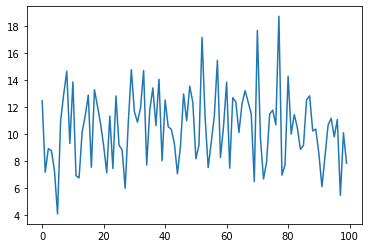

In [16]:
p = torch.Tensor([[0., 1., -1., 0]])
z0 = torch.Tensor([[0., 1.]])
hid_dim = 10

t_max = 6.29*5
n_points = 200

index_np = np.arange(0, n_points, 1, dtype=np.int)
index_np = np.hstack([index_np[:, None]])
times_np = np.linspace(0, t_max, num=n_points)
times_np = np.hstack([times_np[:, None]])
delta = 50

times = torch.from_numpy(times_np[:, :, None]).to(z0)
ode_true = VaeNeuralODE(LinearODEF(p))
obs = ode_true(z0, times, return_whole_sequence=True).detach()
obs = obs + torch.randn_like(obs) * 0.01
obs = obs.detach().requires_grad_(True)
print('Real A:')
print(ode_true.param.view(2,2))

ode_train = SimpleVaeODENeuralNet(delta, hid_dim, p.shape[1])
optimizer = optim.Adam(ode_train.parameters(), lr=0.01)
loss_fn = nn.MSELoss()
train_loss_store = []
train_loss = 0
current_step = 0

#Training 
print('Beginning training...')
for epoch in tqdm(range(100)):
    obs_, ts_ = batch_sampling(obs, times, t_max)
    for i, (x, t) in enumerate(zip(obs_, ts_)): #x.shape = [50, 1, 2]
        current_step += 1
        x = x.squeeze(1)
        x = x[:,0]
        z_, p = ode_train(x, t)
        z_ = z_.squeeze(1)
        loss = loss_fn(z_, x.detach())
        loss.requires_grad_(True)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    train_loss /= (i+1)
    print('predicted A:')
    print(p.reshape(2,2))
    train_loss_store.append(float(train_loss))
    print('epoch:', epoch+1)
    print('step:', current_step)
    print('train loss:', train_loss)
    if epoch%10 == 0:
        plt.plot(x.detach().numpy(), label='Ground Truth')
        plt.plot(z_.detach().numpy(), label='Predicted');
        plt.legend()
        plt.show()
print('...training complete')        
plt.plot(train_loss_store)
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

Real A:
tensor([[ 0.,  1.],
        [-1.,  0.]], grad_fn=<ViewBackward>)
Beginning training...
predicted A:
tensor([[-0.1480,  0.3376],
        [-0.3986, -0.4269]], grad_fn=<AsStridedBackward>)
epoch: 1
step: 100
train loss: 0.3738450813293457


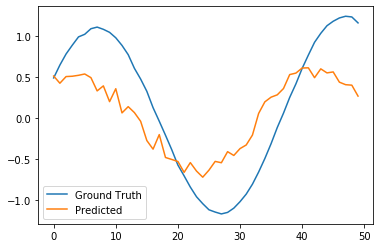

  2%|▏         | 2/100 [00:05<04:54,  3.01s/it]

predicted A:
tensor([[ 0.1412, -0.2231],
        [-0.5413, -0.1626]], grad_fn=<AsStridedBackward>)
epoch: 2
step: 200
train loss: 0.14321962814331055


  3%|▎         | 3/100 [00:08<04:52,  3.01s/it]

predicted A:
tensor([[-0.0074, -0.7814],
        [-0.2992, -0.2001]], grad_fn=<AsStridedBackward>)
epoch: 3
step: 300
train loss: 0.13762089379369466


  4%|▍         | 4/100 [00:11<04:45,  2.97s/it]

predicted A:
tensor([[ 0.0134, -0.7775],
        [-0.3324, -0.1893]], grad_fn=<AsStridedBackward>)
epoch: 4
step: 400
train loss: 0.1624246442646026


  5%|▌         | 5/100 [00:14<04:39,  2.94s/it]

predicted A:
tensor([[-0.3374,  0.0138],
        [-0.1415, -0.4147]], grad_fn=<AsStridedBackward>)
epoch: 5
step: 500
train loss: 0.1404510465571212


  6%|▌         | 6/100 [00:17<04:36,  2.94s/it]

predicted A:
tensor([[ 0.0265, -0.7605],
        [-0.3593, -0.1764]], grad_fn=<AsStridedBackward>)
epoch: 6
step: 600
train loss: 0.13390606126201296


  7%|▋         | 7/100 [00:20<04:30,  2.91s/it]

predicted A:
tensor([[ 0.0439, -0.7020],
        [-0.4048, -0.1535]], grad_fn=<AsStridedBackward>)
epoch: 7
step: 700
train loss: 0.116080718638507


  8%|▊         | 8/100 [00:24<04:55,  3.21s/it]

predicted A:
tensor([[ 0.1359, -0.1110],
        [-0.5551, -0.1750]], grad_fn=<AsStridedBackward>)
epoch: 8
step: 800
train loss: 0.17941036419535186


  9%|▉         | 9/100 [00:27<04:51,  3.21s/it]

predicted A:
tensor([[-0.2338,  0.2650],
        [-0.3022, -0.4390]], grad_fn=<AsStridedBackward>)
epoch: 9
step: 900
train loss: 0.15677611652478224


 10%|█         | 10/100 [00:30<04:39,  3.11s/it]

predicted A:
tensor([[-0.3368, -0.1237],
        [-0.1171, -0.4008]], grad_fn=<AsStridedBackward>)
epoch: 10
step: 1000
train loss: 0.2087842742196932
predicted A:
tensor([[-0.1146,  0.3663],
        [-0.4387, -0.4129]], grad_fn=<AsStridedBackward>)
epoch: 11
step: 1100
train loss: 0.17173605479926962


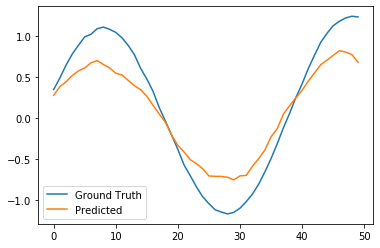

 12%|█▏        | 12/100 [00:36<04:22,  2.98s/it]

predicted A:
tensor([[-0.1998,  0.3171],
        [-0.3507, -0.4365]], grad_fn=<AsStridedBackward>)
epoch: 12
step: 1200
train loss: 0.1673235922397741


 13%|█▎        | 13/100 [00:39<04:16,  2.95s/it]

predicted A:
tensor([[ 0.0559, -0.6578],
        [-0.4231, -0.1460]], grad_fn=<AsStridedBackward>)
epoch: 13
step: 1300
train loss: 0.11919240298103326


 14%|█▍        | 14/100 [00:41<04:10,  2.92s/it]

predicted A:
tensor([[ 0.0659, -0.6018],
        [-0.4393, -0.1376]], grad_fn=<AsStridedBackward>)
epoch: 14
step: 1400
train loss: 0.12934876443523724


 15%|█▌        | 15/100 [00:44<04:06,  2.91s/it]

predicted A:
tensor([[ 0.0134, -0.7775],
        [-0.3324, -0.1893]], grad_fn=<AsStridedBackward>)
epoch: 15
step: 1500
train loss: 0.12794372878975083


 16%|█▌        | 16/100 [00:47<04:02,  2.89s/it]

predicted A:
tensor([[ 0.1140, -0.4232],
        [-0.4933, -0.1344]], grad_fn=<AsStridedBackward>)
epoch: 16
step: 1600
train loss: 0.10707969298092712


 17%|█▋        | 17/100 [00:50<03:56,  2.85s/it]

predicted A:
tensor([[ 0.1412, -0.2231],
        [-0.5413, -0.1626]], grad_fn=<AsStridedBackward>)
epoch: 17
step: 1700
train loss: 0.0928546058698995


 18%|█▊        | 18/100 [00:53<03:58,  2.90s/it]

predicted A:
tensor([[ 0.0907, -0.5266],
        [-0.4726, -0.1435]], grad_fn=<AsStridedBackward>)
epoch: 18
step: 1800
train loss: 0.12555003307525578


 19%|█▉        | 19/100 [00:56<03:57,  2.93s/it]

predicted A:
tensor([[ 0.0098,  0.3006],
        [-0.5248, -0.3224]], grad_fn=<AsStridedBackward>)
epoch: 19
step: 1900
train loss: 0.10973961758909269


 20%|██        | 20/100 [00:59<04:06,  3.09s/it]

predicted A:
tensor([[ 0.1412, -0.2231],
        [-0.5413, -0.1626]], grad_fn=<AsStridedBackward>)
epoch: 20
step: 2000
train loss: 0.12102502099732099
predicted A:
tensor([[ 0.0265, -0.7605],
        [-0.3593, -0.1764]], grad_fn=<AsStridedBackward>)
epoch: 21
step: 2100
train loss: 0.07502898107208593


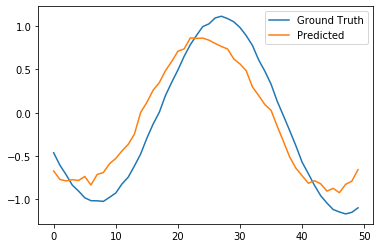

 22%|██▏       | 22/100 [01:06<04:06,  3.16s/it]

predicted A:
tensor([[-0.0074, -0.7814],
        [-0.2992, -0.2001]], grad_fn=<AsStridedBackward>)
epoch: 22
step: 2200
train loss: 0.07653580550792816


 23%|██▎       | 23/100 [01:11<04:56,  3.85s/it]

predicted A:
tensor([[ 0.1412, -0.2231],
        [-0.5413, -0.1626]], grad_fn=<AsStridedBackward>)
epoch: 23
step: 2300
train loss: 0.10071867890802577


 24%|██▍       | 24/100 [01:15<04:56,  3.90s/it]

predicted A:
tensor([[ 0.0659, -0.6018],
        [-0.4393, -0.1376]], grad_fn=<AsStridedBackward>)
epoch: 24
step: 2400
train loss: 0.10936375983526533


 25%|██▌       | 25/100 [01:18<04:32,  3.64s/it]

predicted A:
tensor([[-0.0400, -0.7725],
        [-0.2759, -0.2212]], grad_fn=<AsStridedBackward>)
epoch: 25
step: 2500
train loss: 0.06602445226362921


 26%|██▌       | 26/100 [01:22<04:28,  3.63s/it]

predicted A:
tensor([[ 0.0325, -0.7431],
        [-0.3860, -0.1649]], grad_fn=<AsStridedBackward>)
epoch: 26
step: 2600
train loss: 0.09486635372556887


 27%|██▋       | 27/100 [01:25<04:21,  3.58s/it]

predicted A:
tensor([[-0.0400, -0.7725],
        [-0.2759, -0.2212]], grad_fn=<AsStridedBackward>)
epoch: 27
step: 2700
train loss: 0.05116254228805678


 28%|██▊       | 28/100 [01:29<04:09,  3.46s/it]

predicted A:
tensor([[-0.0074, -0.7814],
        [-0.2992, -0.2001]], grad_fn=<AsStridedBackward>)
epoch: 28
step: 2800
train loss: 0.05272573723086953


 29%|██▉       | 29/100 [01:32<03:56,  3.33s/it]

predicted A:
tensor([[-0.2338,  0.2650],
        [-0.3022, -0.4390]], grad_fn=<AsStridedBackward>)
epoch: 29
step: 2900
train loss: 0.07354626959903184


 30%|███       | 30/100 [01:35<03:44,  3.21s/it]

predicted A:
tensor([[ 0.1359, -0.1110],
        [-0.5551, -0.1750]], grad_fn=<AsStridedBackward>)
epoch: 30
step: 3000
train loss: 0.09584990132523384
predicted A:
tensor([[ 0.0439, -0.7020],
        [-0.4048, -0.1535]], grad_fn=<AsStridedBackward>)
epoch: 31
step: 3100
train loss: 0.09233057474255726


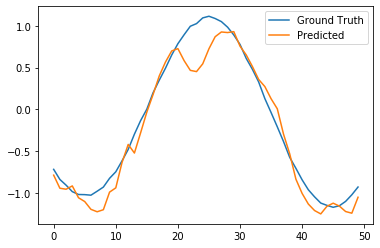

 32%|███▏      | 32/100 [01:40<03:27,  3.04s/it]

predicted A:
tensor([[-0.0400, -0.7725],
        [-0.2759, -0.2212]], grad_fn=<AsStridedBackward>)
epoch: 32
step: 3200
train loss: 0.1093804305837028


 33%|███▎      | 33/100 [01:43<03:17,  2.95s/it]

predicted A:
tensor([[-0.1146,  0.3663],
        [-0.4387, -0.4129]], grad_fn=<AsStridedBackward>)
epoch: 33
step: 3300
train loss: 0.08277480504284472


 34%|███▍      | 34/100 [01:46<03:15,  2.96s/it]

predicted A:
tensor([[-0.2889,  0.2083],
        [-0.2440, -0.4346]], grad_fn=<AsStridedBackward>)
epoch: 34
step: 3400
train loss: 0.047514320425902944


 35%|███▌      | 35/100 [01:50<03:21,  3.10s/it]

predicted A:
tensor([[ 0.0439, -0.7020],
        [-0.4048, -0.1535]], grad_fn=<AsStridedBackward>)
epoch: 35
step: 3500
train loss: 0.05092133209416857


 36%|███▌      | 36/100 [01:53<03:25,  3.21s/it]

predicted A:
tensor([[ 0.1136,  0.0062],
        [-0.5554, -0.1984]], grad_fn=<AsStridedBackward>)
epoch: 36
step: 3600
train loss: 0.03423371393469444


 37%|███▋      | 37/100 [01:56<03:22,  3.21s/it]

predicted A:
tensor([[ 0.1412, -0.2231],
        [-0.5413, -0.1626]], grad_fn=<AsStridedBackward>)
epoch: 37
step: 3700
train loss: 0.03213555342580688


 38%|███▊      | 38/100 [01:59<03:18,  3.20s/it]

predicted A:
tensor([[ 0.0659, -0.6018],
        [-0.4393, -0.1376]], grad_fn=<AsStridedBackward>)
epoch: 38
step: 3800
train loss: 0.053066662289208505


 39%|███▉      | 39/100 [02:03<03:15,  3.21s/it]

predicted A:
tensor([[ 0.0786,  0.1440],
        [-0.5632, -0.2453]], grad_fn=<AsStridedBackward>)
epoch: 39
step: 3900
train loss: 0.07843191132424406


 40%|████      | 40/100 [02:06<03:11,  3.19s/it]

predicted A:
tensor([[-0.0074, -0.7814],
        [-0.2992, -0.2001]], grad_fn=<AsStridedBackward>)
epoch: 40
step: 4000
train loss: 0.046499498174759554
predicted A:
tensor([[-0.3191,  0.0812],
        [-0.1860, -0.4310]], grad_fn=<AsStridedBackward>)
epoch: 41
step: 4100
train loss: 0.029958652795620738


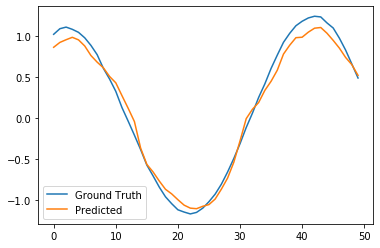

 42%|████▏     | 42/100 [02:12<02:57,  3.06s/it]

predicted A:
tensor([[-0.0074, -0.7814],
        [-0.2992, -0.2001]], grad_fn=<AsStridedBackward>)
epoch: 42
step: 4200
train loss: 0.06341805112662122


 43%|████▎     | 43/100 [02:14<02:48,  2.95s/it]

predicted A:
tensor([[-0.3191,  0.0812],
        [-0.1860, -0.4310]], grad_fn=<AsStridedBackward>)
epoch: 43
step: 4300
train loss: 0.050463874110870284


 44%|████▍     | 44/100 [02:17<02:44,  2.93s/it]

predicted A:
tensor([[ 0.0325, -0.7431],
        [-0.3860, -0.1649]], grad_fn=<AsStridedBackward>)
epoch: 44
step: 4400
train loss: 0.08248249386422256


 45%|████▌     | 45/100 [02:20<02:38,  2.88s/it]

predicted A:
tensor([[ 0.0524,  0.2076],
        [-0.5535, -0.2710]], grad_fn=<AsStridedBackward>)
epoch: 45
step: 4500
train loss: 0.09423712347550169


 46%|████▌     | 46/100 [02:23<02:44,  3.05s/it]

predicted A:
tensor([[ 0.1140, -0.4232],
        [-0.4933, -0.1344]], grad_fn=<AsStridedBackward>)
epoch: 46
step: 4600
train loss: 0.07578348883519972


 47%|████▋     | 47/100 [02:27<02:49,  3.20s/it]

predicted A:
tensor([[ 0.0325, -0.7431],
        [-0.3860, -0.1649]], grad_fn=<AsStridedBackward>)
epoch: 47
step: 4700
train loss: 0.03856804584763936


 48%|████▊     | 48/100 [02:30<02:44,  3.17s/it]

predicted A:
tensor([[-0.3374,  0.0138],
        [-0.1415, -0.4147]], grad_fn=<AsStridedBackward>)
epoch: 48
step: 4800
train loss: 0.055280128614013636


 49%|████▉     | 49/100 [02:33<02:42,  3.18s/it]

predicted A:
tensor([[ 0.1140, -0.4232],
        [-0.4933, -0.1344]], grad_fn=<AsStridedBackward>)
epoch: 49
step: 4900
train loss: 0.09082740929563497


 50%|█████     | 50/100 [02:37<02:40,  3.21s/it]

predicted A:
tensor([[ 0.0389,  0.2558],
        [-0.5430, -0.2937]], grad_fn=<AsStridedBackward>)
epoch: 50
step: 5000
train loss: 0.08787702111179278
predicted A:
tensor([[-0.2889,  0.2083],
        [-0.2440, -0.4346]], grad_fn=<AsStridedBackward>)
epoch: 51
step: 5100
train loss: 0.044242953736672766


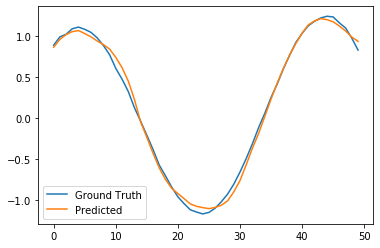

 52%|█████▏    | 52/100 [02:43<02:28,  3.10s/it]

predicted A:
tensor([[-0.0074, -0.7814],
        [-0.2992, -0.2001]], grad_fn=<AsStridedBackward>)
epoch: 52
step: 5200
train loss: 0.05741597866494546


 53%|█████▎    | 53/100 [02:45<02:21,  3.02s/it]

predicted A:
tensor([[-0.1480,  0.3376],
        [-0.3986, -0.4269]], grad_fn=<AsStridedBackward>)
epoch: 53
step: 5300
train loss: 0.07482883323713618


 54%|█████▍    | 54/100 [02:48<02:17,  2.99s/it]

predicted A:
tensor([[-0.2930,  0.1419],
        [-0.2172, -0.4308]], grad_fn=<AsStridedBackward>)
epoch: 54
step: 5400
train loss: 0.0668116041669886


 55%|█████▌    | 55/100 [02:51<02:12,  2.95s/it]

predicted A:
tensor([[-0.0503, -0.2598],
        [-0.3228, -0.2453]], grad_fn=<AsStridedBackward>)
epoch: 55
step: 5500
train loss: 0.033290538978508005


 56%|█████▌    | 56/100 [02:54<02:08,  2.92s/it]

predicted A:
tensor([[ 0.0134, -0.7775],
        [-0.3324, -0.1893]], grad_fn=<AsStridedBackward>)
epoch: 56
step: 5600
train loss: 0.030392154092967756


 57%|█████▋    | 57/100 [02:57<02:06,  2.93s/it]

predicted A:
tensor([[ 0.0907, -0.5266],
        [-0.4726, -0.1435]], grad_fn=<AsStridedBackward>)
epoch: 57
step: 5700
train loss: 0.0243446587698634


 58%|█████▊    | 58/100 [03:00<02:03,  2.95s/it]

predicted A:
tensor([[ 0.0134, -0.7775],
        [-0.3324, -0.1893]], grad_fn=<AsStridedBackward>)
epoch: 58
step: 5800
train loss: 0.040114077014729486


 59%|█████▉    | 59/100 [03:03<02:01,  2.96s/it]

predicted A:
tensor([[ 0.0098,  0.3006],
        [-0.5248, -0.3224]], grad_fn=<AsStridedBackward>)
epoch: 59
step: 5900
train loss: 0.03294725076327447


 60%|██████    | 60/100 [03:06<01:57,  2.93s/it]

predicted A:
tensor([[ 0.0439, -0.7020],
        [-0.4048, -0.1535]], grad_fn=<AsStridedBackward>)
epoch: 60
step: 6000
train loss: 0.041849809218015
predicted A:
tensor([[-0.3368, -0.1237],
        [-0.1171, -0.4008]], grad_fn=<AsStridedBackward>)
epoch: 61
step: 6100
train loss: 0.08496252752825434


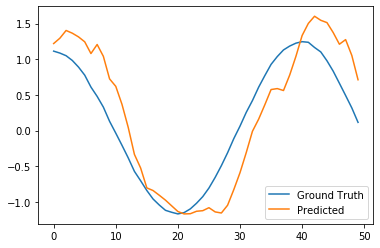

 62%|██████▏   | 62/100 [03:12<01:51,  2.94s/it]

predicted A:
tensor([[ 0.0559, -0.6578],
        [-0.4231, -0.1460]], grad_fn=<AsStridedBackward>)
epoch: 62
step: 6200
train loss: 0.11132192250834627


 63%|██████▎   | 63/100 [03:15<01:48,  2.93s/it]

predicted A:
tensor([[ 0.0659, -0.6018],
        [-0.4393, -0.1376]], grad_fn=<AsStridedBackward>)
epoch: 63
step: 6300
train loss: 0.051626198224260456


 64%|██████▍   | 64/100 [03:18<01:44,  2.90s/it]

predicted A:
tensor([[ 0.0134, -0.7775],
        [-0.3324, -0.1893]], grad_fn=<AsStridedBackward>)
epoch: 64
step: 6400
train loss: 0.032103154242481134


 65%|██████▌   | 65/100 [03:20<01:40,  2.88s/it]

predicted A:
tensor([[-0.0400, -0.7725],
        [-0.2759, -0.2212]], grad_fn=<AsStridedBackward>)
epoch: 65
step: 6500
train loss: 0.051362573370733064


 66%|██████▌   | 66/100 [03:23<01:38,  2.89s/it]

predicted A:
tensor([[-0.1146,  0.3663],
        [-0.4387, -0.4129]], grad_fn=<AsStridedBackward>)
epoch: 66
step: 6600
train loss: 0.025986989182107383


 67%|██████▋   | 67/100 [03:26<01:34,  2.86s/it]

predicted A:
tensor([[ 0.0559, -0.6578],
        [-0.4231, -0.1460]], grad_fn=<AsStridedBackward>)
epoch: 67
step: 6700
train loss: 0.044996905241065324


 68%|██████▊   | 68/100 [03:29<01:32,  2.90s/it]

predicted A:
tensor([[ 0.1136,  0.0062],
        [-0.5554, -0.1984]], grad_fn=<AsStridedBackward>)
epoch: 68
step: 6800
train loss: 0.05963764122322106


 69%|██████▉   | 69/100 [03:32<01:32,  2.98s/it]

predicted A:
tensor([[ 0.1341, -0.3219],
        [-0.5219, -0.1570]], grad_fn=<AsStridedBackward>)
epoch: 69
step: 6900
train loss: 0.04680532797394393


 70%|███████   | 70/100 [03:35<01:31,  3.06s/it]

predicted A:
tensor([[ 0.1341, -0.3219],
        [-0.5219, -0.1570]], grad_fn=<AsStridedBackward>)
epoch: 70
step: 7000
train loss: 0.08845427348261384
predicted A:
tensor([[ 0.0265, -0.7605],
        [-0.3593, -0.1764]], grad_fn=<AsStridedBackward>)
epoch: 71
step: 7100
train loss: 0.06483869582949967


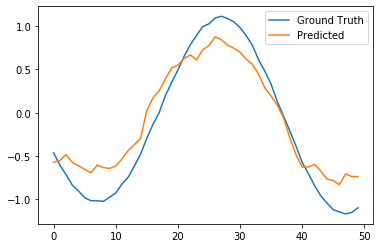

 72%|███████▏  | 72/100 [03:42<01:25,  3.04s/it]

predicted A:
tensor([[ 0.1359, -0.1110],
        [-0.5551, -0.1750]], grad_fn=<AsStridedBackward>)
epoch: 72
step: 7200
train loss: 0.055872635857907575


 73%|███████▎  | 73/100 [03:44<01:20,  2.98s/it]

predicted A:
tensor([[-0.0074, -0.7814],
        [-0.2992, -0.2001]], grad_fn=<AsStridedBackward>)
epoch: 73
step: 7300
train loss: 0.03908419120882412


 74%|███████▍  | 74/100 [03:47<01:16,  2.96s/it]

predicted A:
tensor([[-0.0503, -0.2598],
        [-0.3228, -0.2453]], grad_fn=<AsStridedBackward>)
epoch: 74
step: 7400
train loss: 0.036285244881949646


 75%|███████▌  | 75/100 [03:50<01:14,  2.96s/it]

predicted A:
tensor([[-0.0074, -0.7814],
        [-0.2992, -0.2001]], grad_fn=<AsStridedBackward>)
epoch: 75
step: 7500
train loss: 0.08098905708313761


 76%|███████▌  | 76/100 [03:53<01:10,  2.93s/it]

predicted A:
tensor([[-0.1998,  0.3171],
        [-0.3507, -0.4365]], grad_fn=<AsStridedBackward>)
epoch: 76
step: 7600
train loss: 0.04599697898609087


 77%|███████▋  | 77/100 [03:56<01:07,  2.92s/it]

predicted A:
tensor([[-0.0503, -0.2598],
        [-0.3228, -0.2453]], grad_fn=<AsStridedBackward>)
epoch: 77
step: 7700
train loss: 0.06581845254045925


 78%|███████▊  | 78/100 [03:59<01:03,  2.90s/it]

predicted A:
tensor([[-0.0503, -0.2598],
        [-0.3228, -0.2453]], grad_fn=<AsStridedBackward>)
epoch: 78
step: 7800
train loss: 0.062130156443767716


 79%|███████▉  | 79/100 [04:02<01:01,  2.91s/it]

predicted A:
tensor([[-0.2889,  0.2083],
        [-0.2440, -0.4346]], grad_fn=<AsStridedBackward>)
epoch: 79
step: 7900
train loss: 0.026098406906289392


 80%|████████  | 80/100 [04:05<00:58,  2.94s/it]

predicted A:
tensor([[-0.0503, -0.2598],
        [-0.3228, -0.2453]], grad_fn=<AsStridedBackward>)
epoch: 80
step: 8000
train loss: 0.053952016774309365
predicted A:
tensor([[ 0.0325, -0.7431],
        [-0.3860, -0.1649]], grad_fn=<AsStridedBackward>)
epoch: 81
step: 8100
train loss: 0.038342220769494076


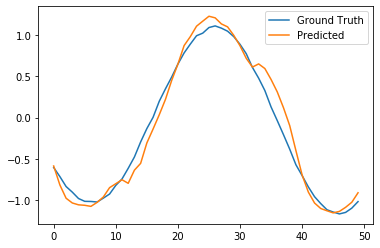

 82%|████████▏ | 82/100 [04:11<00:53,  2.96s/it]

predicted A:
tensor([[ 0.1341, -0.3219],
        [-0.5219, -0.1570]], grad_fn=<AsStridedBackward>)
epoch: 82
step: 8200
train loss: 0.02652825696454614


 83%|████████▎ | 83/100 [04:14<00:50,  2.95s/it]

predicted A:
tensor([[ 0.0134, -0.7775],
        [-0.3324, -0.1893]], grad_fn=<AsStridedBackward>)
epoch: 83
step: 8300
train loss: 0.04927591026779872


 84%|████████▍ | 84/100 [04:17<00:47,  2.96s/it]

predicted A:
tensor([[-0.3277, -0.2631],
        [-0.1128, -0.3950]], grad_fn=<AsStridedBackward>)
epoch: 84
step: 8400
train loss: 0.0379987462914568


 85%|████████▌ | 85/100 [04:20<00:43,  2.92s/it]

predicted A:
tensor([[ 0.0524,  0.2076],
        [-0.5535, -0.2710]], grad_fn=<AsStridedBackward>)
epoch: 85
step: 8500
train loss: 0.04705545317640251


 86%|████████▌ | 86/100 [04:23<00:41,  2.97s/it]

predicted A:
tensor([[ 0.0998,  0.0870],
        [-0.5635, -0.2232]], grad_fn=<AsStridedBackward>)
epoch: 86
step: 8600
train loss: 0.05116841558714189


 87%|████████▋ | 87/100 [04:26<00:38,  2.97s/it]

predicted A:
tensor([[ 0.1136,  0.0062],
        [-0.5554, -0.1984]], grad_fn=<AsStridedBackward>)
epoch: 87
step: 8700
train loss: 0.056558463076443674


 88%|████████▊ | 88/100 [04:28<00:35,  2.93s/it]

predicted A:
tensor([[-0.0666,  0.3514],
        [-0.4884, -0.3798]], grad_fn=<AsStridedBackward>)
epoch: 88
step: 8800
train loss: 0.04536589622899273


 89%|████████▉ | 89/100 [04:31<00:32,  2.92s/it]

predicted A:
tensor([[ 0.0098,  0.3006],
        [-0.5248, -0.3224]], grad_fn=<AsStridedBackward>)
epoch: 89
step: 8900
train loss: 0.0697299738965399


 90%|█████████ | 90/100 [04:34<00:28,  2.87s/it]

predicted A:
tensor([[-0.3368, -0.1237],
        [-0.1171, -0.4008]], grad_fn=<AsStridedBackward>)
epoch: 90
step: 9000
train loss: 0.08424964661462366
predicted A:
tensor([[-0.0400, -0.7725],
        [-0.2759, -0.2212]], grad_fn=<AsStridedBackward>)
epoch: 91
step: 9100
train loss: 0.03001752318560464


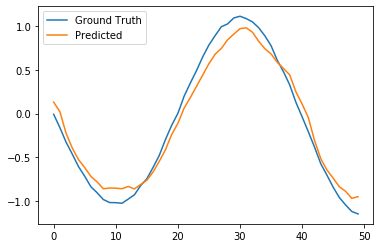

 92%|█████████▏| 92/100 [04:40<00:23,  2.92s/it]

predicted A:
tensor([[ 0.0559, -0.6578],
        [-0.4231, -0.1460]], grad_fn=<AsStridedBackward>)
epoch: 92
step: 9200
train loss: 0.027134928403862505


 93%|█████████▎| 93/100 [04:43<00:20,  2.88s/it]

predicted A:
tensor([[-0.3368, -0.1237],
        [-0.1171, -0.4008]], grad_fn=<AsStridedBackward>)
epoch: 93
step: 9300
train loss: 0.043785262413029304


 94%|█████████▍| 94/100 [04:46<00:17,  2.88s/it]

predicted A:
tensor([[ 0.0659, -0.6018],
        [-0.4393, -0.1376]], grad_fn=<AsStridedBackward>)
epoch: 94
step: 9400
train loss: 0.07387348817337942


 95%|█████████▌| 95/100 [04:49<00:14,  2.86s/it]

predicted A:
tensor([[ 0.0439, -0.7020],
        [-0.4048, -0.1535]], grad_fn=<AsStridedBackward>)
epoch: 95
step: 9500
train loss: 0.04171534464868277


 96%|█████████▌| 96/100 [04:51<00:11,  2.86s/it]

predicted A:
tensor([[-0.0074, -0.7814],
        [-0.2992, -0.2001]], grad_fn=<AsStridedBackward>)
epoch: 96
step: 9600
train loss: 0.04268046762854201


 97%|█████████▋| 97/100 [04:54<00:08,  2.89s/it]

predicted A:
tensor([[ 0.1136,  0.0062],
        [-0.5554, -0.1984]], grad_fn=<AsStridedBackward>)
epoch: 97
step: 9700
train loss: 0.02392077684202831


 98%|█████████▊| 98/100 [04:57<00:05,  2.87s/it]

predicted A:
tensor([[-0.2338,  0.2650],
        [-0.3022, -0.4390]], grad_fn=<AsStridedBackward>)
epoch: 98
step: 9800
train loss: 0.06420796439338342


 99%|█████████▉| 99/100 [05:00<00:02,  2.95s/it]

predicted A:
tensor([[-0.0400, -0.7725],
        [-0.2759, -0.2212]], grad_fn=<AsStridedBackward>)
epoch: 99
step: 9900
train loss: 0.05960297868170849


100%|██████████| 100/100 [05:04<00:00,  3.04s/it]

predicted A:
tensor([[-0.3374,  0.0138],
        [-0.1415, -0.4147]], grad_fn=<AsStridedBackward>)
epoch: 100
step: 10000
train loss: 0.046427779309875614
...training complete


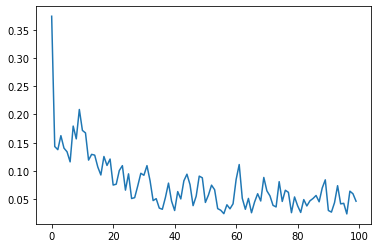

In [430]:
p = torch.Tensor([[0., 1., -1., 0]])
z0 = torch.Tensor([[0., 1.]])
hid_dim = 10

t_max = 6.29*5
n_points = 200

index_np = np.arange(0, n_points, 1, dtype=np.int)
index_np = np.hstack([index_np[:, None]])
times_np = np.linspace(0, t_max, num=n_points)
times_np = np.hstack([times_np[:, None]])
delta = 50

times = torch.from_numpy(times_np[:, :, None]).to(z0)
ode_true = VaeNeuralODE(LinearODEF(p))
obs = ode_true(z0, times, return_whole_sequence=True).detach()
obs = obs + torch.randn_like(obs) * 0.01
obs = obs.detach().requires_grad_(True)
print('Real A:')
print(ode_true.param.view(2,2))

ode_train = VaeODENeuralNet(delta, hid_dim, p.shape[1])
optimizer = optim.Adam(ode_train.parameters(), lr=0.01)
loss_fn = nn.MSELoss()
train_loss_store = []
train_loss = 0
current_step = 0

#Training 
print('Beginning training...')
for epoch in tqdm(range(100)):
    obs_, ts_ = batch_sampling(obs, times, t_max)
    for i, (x, t) in enumerate(zip(obs_, ts_)): #x.shape = [50, 1, 2]
        current_step += 1
        x = x.squeeze(1)
        x = x[:,0]
        z_, p = ode_train(x, t)
        z_ = z_.squeeze(1)
        loss = loss_fn(z_, x.detach())
        loss.requires_grad_(True)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    train_loss /= (i+1)
    print('predicted A:')
    print(p.reshape(2,2))
    train_loss_store.append(float(train_loss))
    print('epoch:', epoch+1)
    print('step:', current_step)
    print('train loss:', train_loss)
    if epoch%10 == 0:
        plt.plot(x.detach().numpy(), label='Ground Truth')
        plt.plot(z_.detach().numpy(), label='Predicted');
        plt.legend()
        plt.show()
print('...training complete')        
plt.plot(train_loss_store)
plt.show()

In [ ]:
#TODO: train with a simplest decoder (without any layers or activation functions)

In [289]:
a = torch.Tensor(50, 1, 2)

In [291]:
a.view(50, 1, 2).shape

torch.Size([50, 1, 2])

In [18]:
a

tensor([1., 2., 3., 4.])

In [19]:
A=a.reshape(2,2)

In [20]:
x = torch.Tensor([0,1])

In [21]:
A.matmul(x)

tensor([2., 4.])

In [4]:
z0 = torch.Tensor([1.,0.])

In [5]:
z = torch.zeros(100,200,2).to(z0)

In [6]:
z.shape

torch.Size([100, 200, 2])

In [242]:
z[0,:,:].shape

torch.Size([200, 2])

In [7]:
t = np.arange(0,10,0.1)

In [8]:
time_len = len(t)

In [9]:
z[0] = z0

In [10]:
A = torch.tensor([[0.,1.], [-1.,0.]])
A

tensor([[ 0.,  1.],
        [-1.,  0.]])

In [11]:
f = lambda x, t, A: A.matmul(x)

In [12]:
for it in range(time_len - 1):
    z0 = ode_solve(z0, t[0], t[1], f, A)
    z[it+1] = z0

In [13]:
z[:,0,0]

tensor([ 1.0000,  0.9975,  0.9850,  0.9626,  0.9304,  0.8888,  0.8381,  0.7787,
         0.7113,  0.6363,  0.5547,  0.4671,  0.3743,  0.2774,  0.1772,  0.0747,
        -0.0290, -0.1330, -0.2361, -0.3374, -0.4359, -0.5304, -0.6202, -0.7041,
        -0.7815, -0.8514, -0.9132, -0.9661, -1.0096, -1.0432, -1.0666, -1.0794,
        -1.0815, -1.0728, -1.0532, -1.0231, -0.9825, -0.9320, -0.8718, -0.8026,
        -0.7251, -0.6399, -0.5478, -0.4499, -0.3469, -0.2400, -0.1301, -0.0183,
         0.0942,  0.2063,  0.3169,  0.4248,  0.5291,  0.6286,  0.7223,  0.8093,
         0.8886,  0.9594,  1.0209,  1.0725,  1.1137,  1.1439,  1.1629,  1.1703,
         1.1660,  1.1500,  1.1225,  1.0835,  1.0336,  0.9730,  0.9024,  0.8225,
         0.7338,  0.6374,  0.5342,  0.4251,  0.3112,  0.1936,  0.0734, -0.0480,
        -0.1696, -0.2901, -0.4083, -0.5230, -0.6331, -0.7373, -0.8348, -0.9243,
        -1.0050, -1.0761, -1.1368, -1.1864, -1.2244, -1.2503, -1.2639, -1.2648,
        -1.2531, -1.2289, -1.1921, -1.14

In [120]:
z.shape

torch.Size([100, 100, 2])

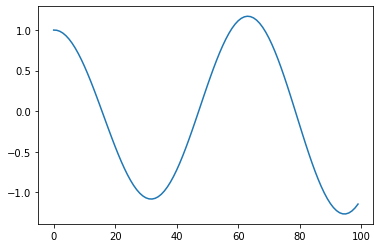

In [14]:
plt.plot(z[:,1,0].numpy())

In [15]:
z0 = torch.Tensor([0.,1.])

In [16]:
z0 = z0.detach().requires_grad_(True)

In [29]:
out = f(z0,t,A)

In [30]:
out

tensor([1., 0.], grad_fn=<MvBackward>)

In [375]:
torch.autograd.grad(out[0], z0, retain_graph=True, create_graph=True)

(tensor([0., 1.], grad_fn=<MvBackward>),)

In [376]:
torch.autograd.grad(out[1], z0, retain_graph=True, create_graph=True)

(tensor([-1.,  0.], grad_fn=<MvBackward>),)

In [377]:
torch.autograd.grad(out[0], A, retain_graph=True, create_graph=True)

(tensor([[0., 1.],
         [0., 0.]], grad_fn=<GerBackward>),)

In [378]:
torch.autograd.grad(out[1], A, retain_graph=True, create_graph=True)

(tensor([[0., 0.],
         [0., 1.]], grad_fn=<GerBackward>),)

In [354]:
A[:,0]

tensor([ 0., -1.], grad_fn=<SelectBackward>)

In [23]:
A.requires_grad_(True)

tensor([[ 0.,  1.],
        [-1.,  0.]], requires_grad=True)

In [19]:
torch.autograd.grad(out, z0, grad_outputs=torch.Tensor([0.,1.]))

(tensor([-1.,  0.]),)

In [31]:
torch.autograd.grad(out, A, grad_outputs=torch.Tensor([[1.,0.], [0.,1.]]), retain_graph=True, create_graph=True)

(tensor([[0., 1.],
         [0., 1.]], grad_fn=<GerBackward>),)